In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime as dt
from copy import deepcopy as dc
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from api_keys import coinapi_key


2023-09-12 19:57:21.720715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull BTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-12T00:00:00.0000000Z', 'time_period_end': '2023-09-13T00:00:00.0000000Z', 'time_open': '2023-09-12T00:00:20.4450000Z', 'time_close': '2023-09-12T23:57:27.4960000Z', 'price_open': 25157, 'price_high': 26529, 'price_low': 25129, 'price_close': 25832, 'volume_traded': 3093.33894167, 'trades_count': 18113}, {'time_period_start': '2023-09-11T00:00:00.0000000Z', 'time_period_end': '2023-09-12T00:00:00.0000000Z', 'time_open': '2023-09-11T00:01:04.0430000Z', 'time_close': '2023-09-11T23:59:54.2240000Z', 'price_open': 25839, 'price_high': 25881, 'price_low': 24920, 'price_close': 25155, 'volume_traded': 2008.59407571, 'trades_count': 15049}, {'time_period_start': '2023-09-10T00:00:00.0000000Z', 'time_period_end': '2023-09-11T00:00:00.0000000Z', 'time_open': '2023-09-10T00:00:25.1010000Z', 'time_close': '2023-09-10T23:58:35.8900000Z', 'price_open': 25899, 'price_high': 26018, 'price_low': 25588, 'price_close': 25836, 'volume_traded': 879.78612157, 'trades_count': 

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-12T00:00:00.0000000Z,2023-09-13T00:00:00.0000000Z,2023-09-12T00:00:20.4450000Z,2023-09-12T23:57:27.4960000Z,25157.0,26529.0,25129.0,25832.0,3093.338942,18113
1,2023-09-11T00:00:00.0000000Z,2023-09-12T00:00:00.0000000Z,2023-09-11T00:01:04.0430000Z,2023-09-11T23:59:54.2240000Z,25839.0,25881.0,24920.0,25155.0,2008.594076,15049
2,2023-09-10T00:00:00.0000000Z,2023-09-11T00:00:00.0000000Z,2023-09-10T00:00:25.1010000Z,2023-09-10T23:58:35.8900000Z,25899.0,26018.0,25588.0,25836.0,879.786122,7268
3,2023-09-09T00:00:00.0000000Z,2023-09-10T00:00:00.0000000Z,2023-09-09T00:00:01.0120000Z,2023-09-09T23:59:53.1500000Z,25908.0,25927.0,25801.0,25899.0,438.781895,6596
4,2023-09-08T00:00:00.0000000Z,2023-09-09T00:00:00.0000000Z,2023-09-08T00:00:00.8150000Z,2023-09-08T23:58:52.5340000Z,26256.0,26429.0,25652.0,25908.0,1646.440292,13583


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87
...,...
2023-09-08,25908.00
2023-09-09,25899.00
2023-09-10,25836.00


In [5]:
close = data['Close']

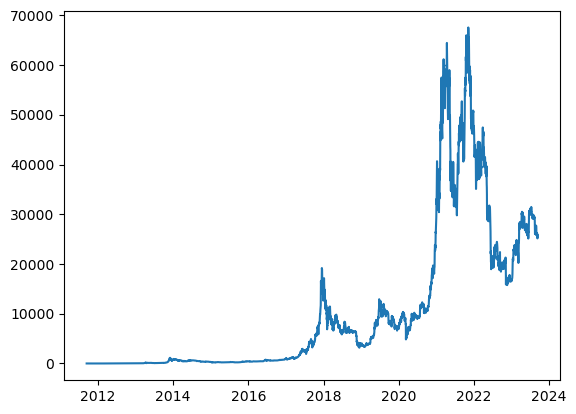

In [6]:
#plot historical eth price
plt.plot(close)

In [7]:
# build 1 week lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 30
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),Close(t-8),Close(t-9),...,Close(t-21),Close(t-22),Close(t-23),Close(t-24),Close(t-25),Close(t-26),Close(t-27),Close(t-28),Close(t-29),Close(t-30)
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-20,2.24,3.92,4.05,3.97,3.93,4.10,4.51,3.89,3.99,4.61,...,5.72,5.66,5.66,4.90,4.92,4.87,4.85,5.13,5.53,5.97
2011-10-21,2.27,2.24,3.92,4.05,3.97,3.93,4.10,4.51,3.89,3.99,...,5.72,5.72,5.66,5.66,4.90,4.92,4.87,4.85,5.13,5.53
2011-10-24,2.92,2.27,2.24,3.92,4.05,3.97,3.93,4.10,4.51,3.89,...,5.68,5.72,5.72,5.66,5.66,4.90,4.92,4.87,4.85,5.13
2011-10-25,2.72,2.92,2.27,2.24,3.92,4.05,3.97,3.93,4.10,4.51,...,6.05,5.68,5.72,5.72,5.66,5.66,4.90,4.92,4.87,4.85
2011-10-26,2.69,2.72,2.92,2.27,2.24,3.92,4.05,3.97,3.93,4.10,...,4.80,6.05,5.68,5.72,5.72,5.66,5.66,4.90,4.92,4.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-08,25908.00,26245.00,25748.00,25783.00,25819.00,25970.00,25870.00,25798.00,25932.00,27300.00,...,26051.00,26642.00,28701.00,29172.00,29408.00,29284.00,29415.00,29398.00,29423.00,29565.00
2023-09-09,25899.00,25908.00,26245.00,25748.00,25783.00,25819.00,25970.00,25870.00,25798.00,25932.00,...,26097.00,26051.00,26642.00,28701.00,29172.00,29408.00,29284.00,29415.00,29398.00,29423.00
2023-09-10,25836.00,25899.00,25908.00,26245.00,25748.00,25783.00,25819.00,25970.00,25870.00,25798.00,...,26192.00,26097.00,26051.00,26642.00,28701.00,29172.00,29408.00,29284.00,29415.00,29398.00


In [8]:
#create array of dates for plotting from index. Must be shifted by 7 to match time series data, 
# since time series is 7 days and does not generate until the 7th day
# data starts on 9/13/11, but series don't start until 9/20
dates = data.index
dates = dates[lookback:]
dates.shape

(4200,)

In [9]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[2.2400e+00, 3.9200e+00, 4.0500e+00, ..., 5.1300e+00, 5.5300e+00,
        5.9700e+00],
       [2.2700e+00, 2.2400e+00, 3.9200e+00, ..., 4.8500e+00, 5.1300e+00,
        5.5300e+00],
       [2.9200e+00, 2.2700e+00, 2.2400e+00, ..., 4.8700e+00, 4.8500e+00,
        5.1300e+00],
       ...,
       [2.5836e+04, 2.5899e+04, 2.5908e+04, ..., 2.9284e+04, 2.9415e+04,
        2.9398e+04],
       [2.5155e+04, 2.5836e+04, 2.5899e+04, ..., 2.9408e+04, 2.9284e+04,
        2.9415e+04],
       [2.5832e+04, 2.5155e+04, 2.5836e+04, ..., 2.9172e+04, 2.9408e+04,
        2.9284e+04]])

In [10]:
shifted_df_as_np.shape

(4200, 31)

In [11]:
# # scale data with min/max scaler

# scaler = MinMaxScaler(feature_range=(-1, 1))
# shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# shifted_df_as_np

In [12]:

shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np_int)

In [13]:
log_transformed_data

array([[ 0.69314718,  1.09861229,  1.38629436, ...,  1.60943791,
         1.60943791,  1.60943791],
       [ 0.69314718,  0.69314718,  1.09861229, ...,  1.38629436,
         1.60943791,  1.60943791],
       [ 0.69314718,  0.69314718,  0.69314718, ...,  1.38629436,
         1.38629436,  1.60943791],
       ...,
       [10.15952415, 10.16195964, 10.16230708, ..., 10.28479657,
        10.28926003, 10.28868192],
       [10.13281196, 10.15952415, 10.16195964, ..., 10.28902203,
        10.28479657, 10.28926003],
       [10.15936931, 10.13281196, 10.15952415, ..., 10.28096462,
        10.28902203, 10.28479657]])

In [14]:
# check shapes
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

X1.shape, y1.shape

((4200, 30), (4200,))

In [15]:
X1 = dc(np.flip(X1, axis=1))
X1

array([[ 1.60943791,  1.60943791,  1.60943791, ...,  1.09861229,
         1.38629436,  1.09861229],
       [ 1.60943791,  1.60943791,  1.38629436, ...,  1.38629436,
         1.09861229,  0.69314718],
       [ 1.60943791,  1.38629436,  1.38629436, ...,  1.09861229,
         0.69314718,  0.69314718],
       ...,
       [10.28868192, 10.28926003, 10.28479657, ..., 10.17523077,
        10.16230708, 10.16195964],
       [10.28926003, 10.28479657, 10.28902203, ..., 10.16230708,
        10.16195964, 10.15952415],
       [10.28479657, 10.28902203, 10.28096462, ..., 10.16195964,
        10.15952415, 10.13281196]])

In [16]:
dates_train1, X_train1, y_train1 = dates[:3000],X1[:3000], y1[:3000]
dates_val1, X_val1, y_val1 = dates[3000:3500], X1[3000:3500], y1[3000:3500]
dates_test1, X_test1, y_test1 = dates[3500:], X1[3500:], y1[3500:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3000, 30), (3000,), (500, 30), (500,), (700, 30), (700,))

In [17]:
model = Sequential([layers.Input((30, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-09-12 19:57:39.068334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
94/94 [==============================] - 13s 52ms/step - loss: 9.4937 - mean_absolute_error: 1.9151 - val_loss: 0.4427 - val_mean_absolute_error: 0.5372
Epoch 2/100
94/94 [==============================] - 2s 25ms/step - loss: 0.0097 - mean_absolute_error: 0.0673 - val_loss: 0.3620 - val_mean_absolute_error: 0.4870
Epoch 3/100
94/94 [==============================] - 2s 26ms/step - loss: 0.0088 - mean_absolute_error: 0.0637 - val_loss: 0.2946 - val_mean_absolute_error: 0.4305
Epoch 4/100
94/94 [==============================] - 2s 24ms/step - loss: 0.0090 - mean_absolute_error: 0.0661 - val_loss: 0.3088 - val_mean_absolute_error: 0.4585
Epoch 5/100
94/94 [==============================] - 2s 24ms/step - loss: 0.0079 - mean_absolute_error: 0.0606 - val_loss: 0.2529 - val_mean_absolute_error: 0.4000
Epoch 6/100
94/94 [==============================] - 2s 27ms/step - loss: 0.0070 - mean_absolute_error: 0.0558 - val_loss: 0.2190 - val_mean_absolute_error: 0.3768
Epoch 7/100
94/

Epoch 51/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0047 - mean_absolute_error: 0.0463 - val_loss: 0.0368 - val_mean_absolute_error: 0.1642
Epoch 52/100
94/94 [==============================] - 2s 18ms/step - loss: 0.0043 - mean_absolute_error: 0.0432 - val_loss: 0.0109 - val_mean_absolute_error: 0.0820
Epoch 53/100
94/94 [==============================] - 2s 23ms/step - loss: 0.0044 - mean_absolute_error: 0.0427 - val_loss: 0.0258 - val_mean_absolute_error: 0.1346
Epoch 54/100
94/94 [==============================] - 2s 21ms/step - loss: 0.0039 - mean_absolute_error: 0.0393 - val_loss: 0.0263 - val_mean_absolute_error: 0.1331
Epoch 55/100
94/94 [==============================] - 2s 17ms/step - loss: 0.0046 - mean_absolute_error: 0.0449 - val_loss: 0.0210 - val_mean_absolute_error: 0.1124
Epoch 56/100
94/94 [==============================] - 2s 22ms/step - loss: 0.0050 - mean_absolute_error: 0.0495 - val_loss: 0.0189 - val_mean_absolute_error: 0.1068
Epoch 57/1

94/94 [==============================] - 1s 5ms/step


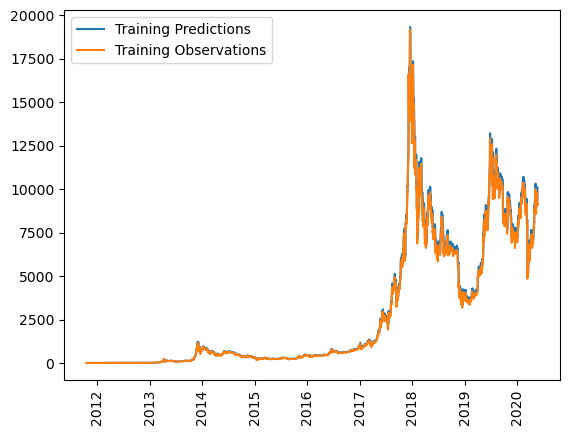

In [18]:
train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

16/16 [==============================] - 0s 6ms/step


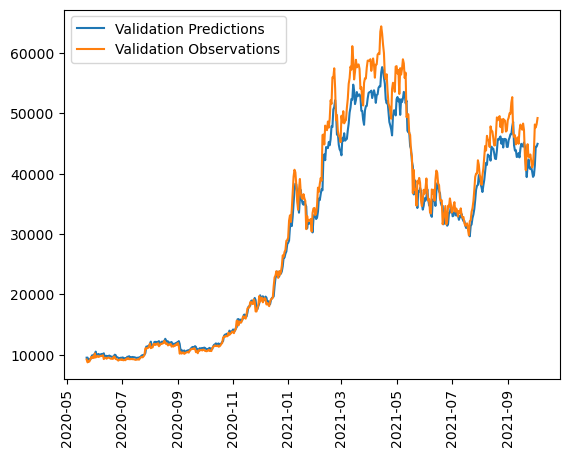

In [19]:
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

22/22 [==============================] - 0s 5ms/step


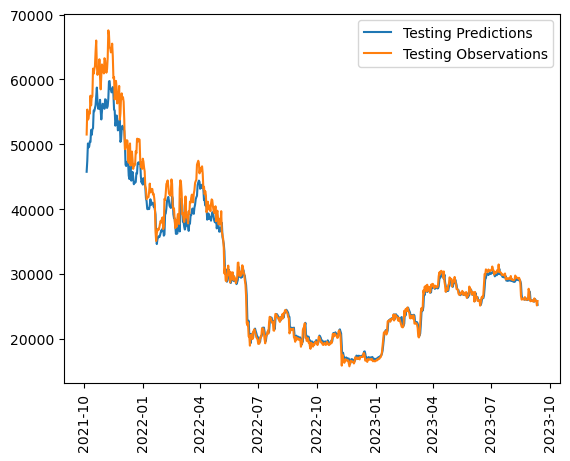

In [20]:
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [21]:
#change timeframe - limit to more recent

dates_train2, X_train2, y_train2 = dates[3000:3800],X1[3000:3800], y1[3000:3800]
dates_val2, X_val2, y_val2 = dates[3800:4000], X1[3800:4000], y1[3800:4000]
dates_test2, X_test2, y_test2 = dates[4000:], X1[4000:], y1[4000:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((800,),
 (800, 30),
 (800,),
 (200,),
 (200, 30),
 (200,),
 (200,),
 (200, 30),
 (200,))

In [22]:
model2 = Sequential([layers.Input((30, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100)

Epoch 1/100
25/25 [==============================] - 4s 53ms/step - loss: 61.8016 - mean_absolute_error: 7.7055 - val_loss: 18.1277 - val_mean_absolute_error: 4.2556
Epoch 2/100
25/25 [==============================] - 0s 17ms/step - loss: 5.2087 - mean_absolute_error: 1.8399 - val_loss: 2.1188 - val_mean_absolute_error: 1.4496
Epoch 3/100
25/25 [==============================] - 0s 18ms/step - loss: 0.5747 - mean_absolute_error: 0.6455 - val_loss: 0.0727 - val_mean_absolute_error: 0.2359
Epoch 4/100
25/25 [==============================] - 0s 19ms/step - loss: 0.4062 - mean_absolute_error: 0.5251 - val_loss: 0.1582 - val_mean_absolute_error: 0.3758
Epoch 5/100
25/25 [==============================] - 0s 19ms/step - loss: 0.3936 - mean_absolute_error: 0.5439 - val_loss: 0.2049 - val_mean_absolute_error: 0.4336
Epoch 6/100
25/25 [==============================] - 0s 19ms/step - loss: 0.3901 - mean_absolute_error: 0.5295 - val_loss: 0.1665 - val_mean_absolute_error: 0.3870
Epoch 7/100
25

Epoch 51/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_absolute_error: 0.0451 - val_loss: 0.0018 - val_mean_absolute_error: 0.0299
Epoch 52/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0034 - mean_absolute_error: 0.0461 - val_loss: 0.0025 - val_mean_absolute_error: 0.0400
Epoch 53/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0038 - mean_absolute_error: 0.0487 - val_loss: 0.0017 - val_mean_absolute_error: 0.0280
Epoch 54/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0030 - mean_absolute_error: 0.0428 - val_loss: 0.0016 - val_mean_absolute_error: 0.0265
Epoch 55/100
25/25 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0472 - val_loss: 0.0018 - val_mean_absolute_error: 0.0299
Epoch 56/100
25/25 [==============================] - 0s 17ms/step - loss: 0.0032 - mean_absolute_error: 0.0448 - val_loss: 0.0043 - val_mean_absolute_error: 0.0565
Epoch 57/1

25/25 [==============================] - 1s 6ms/step


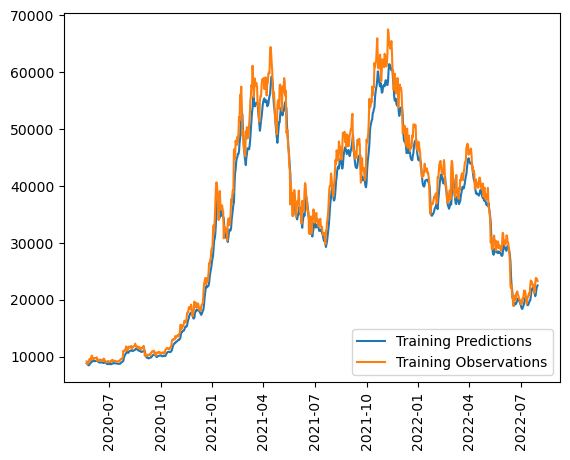

In [23]:
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 1s 7ms/step


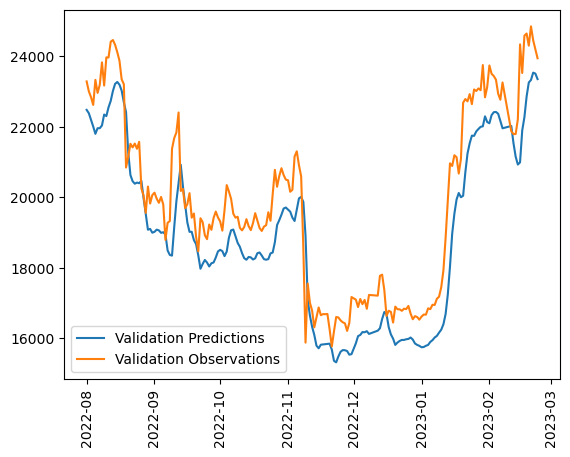

In [24]:
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 6ms/step


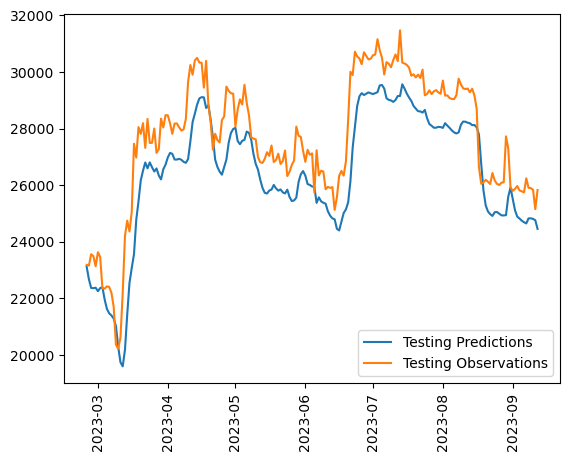

In [25]:
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [26]:
model3 = Sequential([layers.Input((30, 1)),
                    layers.LSTM(64),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(64, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=200)

Epoch 1/200
25/25 [==============================] - 3s 42ms/step - loss: 65.0857 - mean_absolute_error: 7.8261 - val_loss: 9.5163 - val_mean_absolute_error: 3.0820
Epoch 2/200
25/25 [==============================] - 0s 18ms/step - loss: 3.1223 - mean_absolute_error: 1.4635 - val_loss: 0.0171 - val_mean_absolute_error: 0.1096
Epoch 3/200
25/25 [==============================] - 1s 22ms/step - loss: 0.6184 - mean_absolute_error: 0.6659 - val_loss: 0.5027 - val_mean_absolute_error: 0.6972
Epoch 4/200
25/25 [==============================] - 0s 18ms/step - loss: 0.4005 - mean_absolute_error: 0.5347 - val_loss: 0.1557 - val_mean_absolute_error: 0.3732
Epoch 5/200
25/25 [==============================] - 0s 17ms/step - loss: 0.3797 - mean_absolute_error: 0.5236 - val_loss: 0.1708 - val_mean_absolute_error: 0.3931
Epoch 6/200
25/25 [==============================] - 0s 17ms/step - loss: 0.3754 - mean_absolute_error: 0.5216 - val_loss: 0.1597 - val_mean_absolute_error: 0.3791
Epoch 7/200
25/

Epoch 51/200
25/25 [==============================] - 0s 18ms/step - loss: 0.0037 - mean_absolute_error: 0.0469 - val_loss: 0.0023 - val_mean_absolute_error: 0.0352
Epoch 52/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0036 - mean_absolute_error: 0.0460 - val_loss: 0.0025 - val_mean_absolute_error: 0.0382
Epoch 53/200
25/25 [==============================] - 0s 15ms/step - loss: 0.0036 - mean_absolute_error: 0.0468 - val_loss: 0.0030 - val_mean_absolute_error: 0.0434
Epoch 54/200
25/25 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0459 - val_loss: 0.0025 - val_mean_absolute_error: 0.0379
Epoch 55/200
25/25 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0460 - val_loss: 0.0020 - val_mean_absolute_error: 0.0307
Epoch 56/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_absolute_error: 0.0484 - val_loss: 0.0021 - val_mean_absolute_error: 0.0334
Epoch 57/2

Epoch 101/200
25/25 [==============================] - 0s 18ms/step - loss: 0.0032 - mean_absolute_error: 0.0434 - val_loss: 0.0028 - val_mean_absolute_error: 0.0439
Epoch 102/200
25/25 [==============================] - 0s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0402 - val_loss: 0.0019 - val_mean_absolute_error: 0.0324
Epoch 103/200
25/25 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_absolute_error: 0.0535 - val_loss: 0.0016 - val_mean_absolute_error: 0.0288
Epoch 104/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0031 - mean_absolute_error: 0.0433 - val_loss: 0.0107 - val_mean_absolute_error: 0.0983
Epoch 105/200
25/25 [==============================] - 0s 16ms/step - loss: 0.0048 - mean_absolute_error: 0.0556 - val_loss: 0.0020 - val_mean_absolute_error: 0.0346
Epoch 106/200
25/25 [==============================] - 0s 17ms/step - loss: 0.0031 - mean_absolute_error: 0.0433 - val_loss: 0.0034 - val_mean_absolute_error: 0.0496
Epoc

25/25 [==============================] - 0s 14ms/step - loss: 0.0033 - mean_absolute_error: 0.0453 - val_loss: 0.0012 - val_mean_absolute_error: 0.0226
Epoch 151/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_absolute_error: 0.0427 - val_loss: 0.0012 - val_mean_absolute_error: 0.0223
Epoch 152/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_absolute_error: 0.0366 - val_loss: 0.0021 - val_mean_absolute_error: 0.0370
Epoch 153/200
25/25 [==============================] - 0s 19ms/step - loss: 0.0022 - mean_absolute_error: 0.0363 - val_loss: 0.0012 - val_mean_absolute_error: 0.0221
Epoch 154/200
25/25 [==============================] - 0s 15ms/step - loss: 0.0028 - mean_absolute_error: 0.0408 - val_loss: 0.0036 - val_mean_absolute_error: 0.0521
Epoch 155/200
25/25 [==============================] - 0s 18ms/step - loss: 0.0026 - mean_absolute_error: 0.0394 - val_loss: 0.0014 - val_mean_absolute_error: 0.0258
Epoch 156/200
25/2

25/25 [==============================] - 0s 15ms/step - loss: 0.0023 - mean_absolute_error: 0.0380 - val_loss: 0.0019 - val_mean_absolute_error: 0.0353
Epoch 200/200
25/25 [==============================] - 0s 14ms/step - loss: 0.0031 - mean_absolute_error: 0.0435 - val_loss: 0.0019 - val_mean_absolute_error: 0.0329


In [27]:
# Evaluate the model using the test data
model_loss, model_mse = model3.evaluate(X_test2,y_test2,verbose=2)
print(f"Loss: {model_loss}, Mean Absolute Error: {model_mse}")

7/7 - 0s - loss: 0.0016 - mean_absolute_error: 0.0355 - 59ms/epoch - 8ms/step
Loss: 0.001640726812183857, Mean Absolute Error: 0.03546597808599472


25/25 [==============================] - 1s 6ms/step


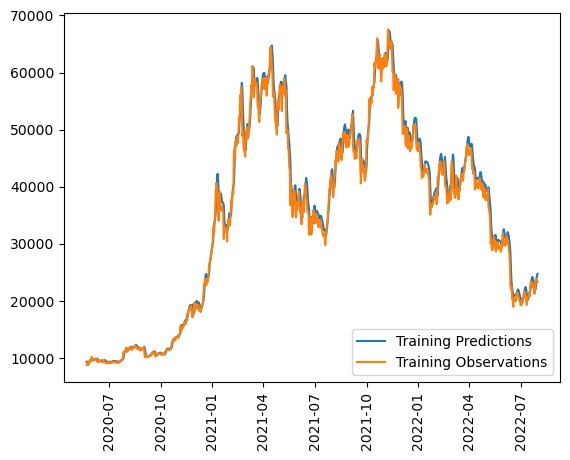

In [28]:
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 1s 7ms/step


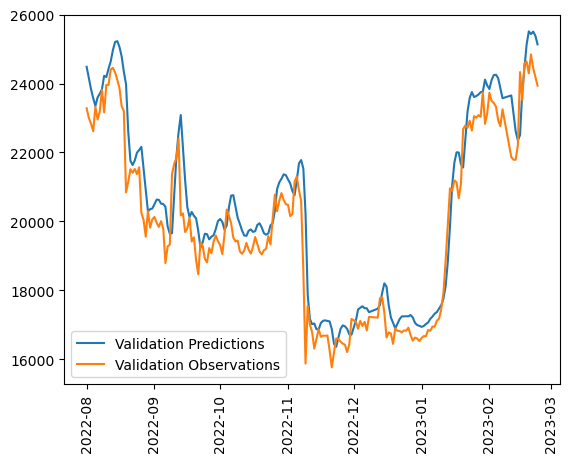

In [29]:
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 [==============================] - 0s 9ms/step


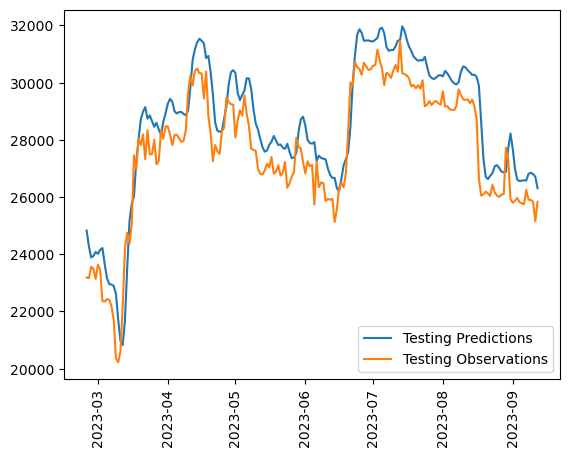

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 2

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1].reshape((1, 30, 1))
initial_date = dates_test2[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
#'predictions' contains forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 27ms/step
[10.177721, 10.187567]
2023-09-13
2023-09-14


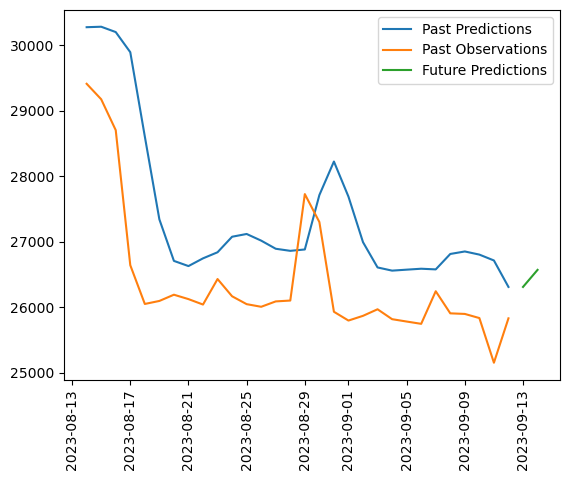

In [32]:
plt.plot(dates_test2[-30:], np.exp(test_predictions3[-30:]))
plt.plot(dates_test2[-30:],np.exp(y_test2[-30:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

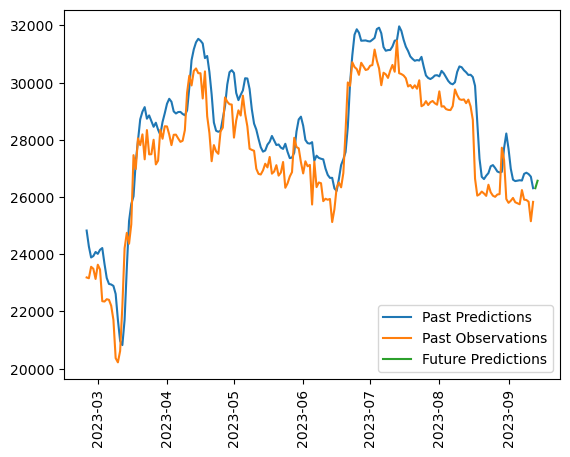

In [33]:
#full range 
plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

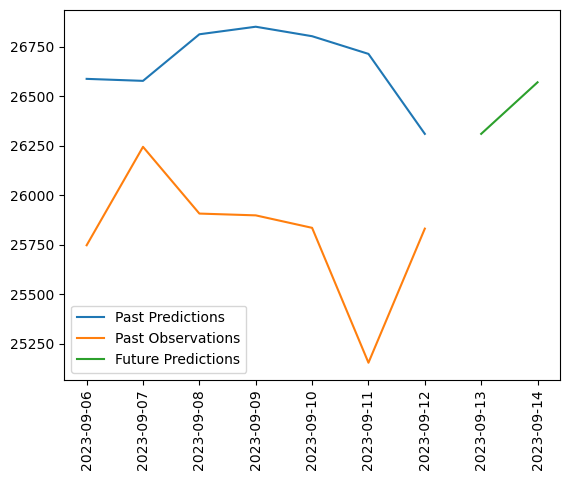

In [34]:
plt.plot(dates_test2[-7:], np.exp(test_predictions3[-7:]))
plt.plot(dates_test2[-7:],np.exp(y_test2[-7:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [35]:
# Export our model to HDF5 file
model3.save("H5_Files/BTC_30_day_lookback.h5")